# IRWA Project Part 2

|Name | Email | UPF uNum |
| --- | --- | --- |
| Clara Pena | clara.pena01@estudiant.upf.edu | u186416 |
| Yuyan Wang | yuyan.wang01@estudiant.upf.edu | u199907 |

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from array import array
from nltk import PorterStemmer, word_tokenize, SnowballStemmer
from nltk.corpus import stopwords
from collections import Counter
import math
import numpy.linalg as la
import string
import textwrap
import re
import warnings
from numpy.linalg import norm
from nltk.tokenize import TweetTokenizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import altair as alt

In [2]:
df = pd.read_csv("./data/processed_data.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117405 entries, 0 to 117404
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        117405 non-null  int64 
 1   content   117404 non-null  object
 2   date      117405 non-null  object
 3   hashtags  116794 non-null  object
 4   likes     117405 non-null  int64 
 5   retweets  117405 non-null  int64 
 6   url       117405 non-null  object
 7   language  117405 non-null  object
 8   docId     48427 non-null   object
dtypes: int64(3), object(6)
memory usage: 8.1+ MB


We'll be working with those tweets that have a document ID associated with them; that is, the value in the docID column should not be NaN. This is basically taking those tweets in English. Besides that, for simplicity, we're not using the column language anymore, so it can be dropped.

In [3]:
tweets_df = df.dropna(subset=['docId']).drop(columns=['language'])

In [4]:
tweets_df.head(10)

,id,content,date,hashtags,likes,retweets,url,docId
1,1364506167226032128,watch full video farmersprotest nofarmersnofoo...,2021-02-24T09:23:16+00:00,#farmersprotest #NoFarmersNoFood,0,0,https://twitter.com/anmoldhaliwal/status/13645...,doc_2
6,1364505991887347714,watch full video farmersprotest nofarmersnofood,2021-02-24T09:22:34+00:00,#farmersprotest #NoFarmersNoFood,0,0,https://twitter.com/anmoldhaliwal/status/13645...,doc_3
9,1364505813834989568,watch full video farmersprotest nofarmersnofood,2021-02-24T09:21:51+00:00,#farmersprotest #NoFarmersNoFood,0,0,https://twitter.com/anmoldhaliwal/status/13645...,doc_4
10,1364505749359976448,anoth farmer malkeet singh mahilpur hoshiarpur...,2021-02-24T09:21:36+00:00,#FarmersProtest,3,3,https://twitter.com/ShariaActivist/status/1364...,doc_5
14,1364505676375076867,hi tell boss modidontsellfarm thank farmerspro...,2021-02-24T09:21:19+00:00,#ModiDontSellFarmers #FarmersProtest,0,0,https://twitter.com/KaurDosanjh1979/status/136...,doc_6
16,1364505511073300481,watch full video farmersprotest nofarmersnofood,2021-02-24T09:20:39+00:00,#farmersprotest #NoFarmersNoFood,0,0,https://twitter.com/anmoldhaliwal/status/13645...,doc_7
18,1364505452134817795,despit increas tax petroldiesel must increas t...,2021-02-24T09:20:25+00:00,#taxes #petrolDiesel #taxes #alcohol #cigarett...,1,1,https://twitter.com/Satende09192805/status/136...,doc_8
20,1364505443997937669,mockeri menac sedit charg farmersprotest,2021-02-24T09:20:23+00:00,#sedition #FarmersProtest,0,0,https://twitter.com/algo_121/status/1364505443...,doc_9
25,1364505314586951680,watch full video farmersprotest nofarmersnofood,2021-02-24T09:19:52+00:00,#farmersprotest #NoFarmersNoFood,0,0,https://twitter.com/anmoldhaliwal/status/13645...,doc_10
26,1364505255946379268,left hear modi lol farmersprotest,2021-02-24T09:19:38+00:00,#FarmersProtest,1,0,https://twitter.com/kdhanjal12/status/13645052...,doc_11


In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48427 entries, 1 to 117404
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48427 non-null  int64 
 1   content   48427 non-null  object
 2   date      48427 non-null  object
 3   hashtags  48153 non-null  object
 4   likes     48427 non-null  int64 
 5   retweets  48427 non-null  int64 
 6   url       48427 non-null  object
 7   docId     48427 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.3+ MB


## Indexing

### Build inverted index

In [6]:
def create_index(df):
    index = defaultdict(list)
    
    for idx, row in df.iterrows():
        doc_id = row['docId']
        terms = row['content'].split()
        
        current_page_index = {}
        for position, term in enumerate(terms):
            if term in current_page_index:
                current_page_index[term][1].append(position)
            else:
                current_page_index[term] = [doc_id, array('I', [position])]  # 'I' for array of unsigned ints.

        # Merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

    return index

In [7]:
index = create_index(tweets_df)

In [8]:
print(len(index))

30477


In [9]:
def build_terms(line):
    # stemmer = PorterStemmer()
    stemmer = SnowballStemmer("english")
    stop_words = set(stopwords.words("english"))
    line = line.lower()

    # Handle contractions by removing possessive endings and common contractions
    line = re.sub(r"\b(\w+)'s\b", r'\1', line)  # Changes "people's" to "people"
    line = re.sub(r"\b(\w+)n't\b", r'\1 not', line)  # Changes "isn't" to "is not"
    line = re.sub(r"\b(\w+)'ll\b", r'\1 will', line)  # Changes "I'll" to "I will"
    line = re.sub(r"\b(\w+)'d\b", r'\1 would', line)  # Changes "I'd" to "I would"
    line = re.sub(r"\b(\w+)'re\b", r'\1 are', line)  # Changes "you're" to "you are"
    line = re.sub(r"\b(\w+)'ve\b", r'\1 have', line)  # Changes "I've" to "I have"

    line = line.split()

    table = str.maketrans('', '', string.punctuation)
    line = [w.translate(table) for w in line]
    line = [w for w in line if w not in stop_words]
    line = [stemmer.stem(w) for w in line] 
    return line

In [10]:
def search(query, index):
    query = build_terms(query)  # Normalize and tokenize the query.
    docs = None  # Initialize docs as None to handle the intersection.

    for term in query:
        try:
            # Extract the document IDs for the term.
            term_docs = set([posting[0] for posting in index[term]])

            if docs is None:
                # Initialize docs with the set of document IDs for the first term.
                docs = term_docs
            else:
                # Intersect the sets of document IDs.
                docs = docs.intersection(term_docs)
        except KeyError:
            # If the term is not in the index, return an empty list because no documents can satisfy the query.
            return []

    if docs is None:
        return []  # If no terms were processed, return an empty list.
    else:
        return list(docs)  # Convert the set to a list before returning.

### Propose test queries

In [11]:
# Calculate the top n terms in the DataFrame for the specified column.
def get_top_terms(df, column='content', top_n=10):
    text = ' '.join(df[column].dropna())  # Combine all text and convert to lower case.
    words = text.split()
    # Get a count of all words
    word_count = Counter(words)
    # Return the most common words
    return word_count.most_common(top_n)

top_terms = get_top_terms(tweets_df, column='content', top_n=20)
print(top_terms)

[('farmersprotest', 50272), ('farmer', 17421), ('india', 7724), ('support', 6004), ('protest', 4787), ('amp', 4728), ('right', 3594), ('peopl', 3526), ('modi', 3113), ('indian', 3008), ('govern', 2753), ('bjp', 2649), ('law', 2570), ('releasedetainedfarm', 2432), ('govt', 2338), ('stand', 2207), ('farmersmakeindia', 2133), ('indiabeingsilenc', 2133), ('thank', 2129), ('farm', 2066)]


1.	“India protest”: This query aligns with the high frequency of terms like ‘india’ (7724 occurrences) and ‘protest’ (4787 occurrences). It targets the significant discussion around protests in India, capturing a broad yet significant topic within your dataset. This is crucial for understanding general sentiments or events related to protests in the region.
2.	“support farmers”: Given the prevalence of terms such as ‘farmersprotest’ (50272 occurrences) and ‘support’ (6004 occurrences), this query is highly relevant. It specifically addresses the widespread discourse on supporting farmers, likely related to agricultural policies or farmer welfare, which seems to be a prominent issue in your data.
3.	“Modi shame”: This query is crafted around the high occurrence of ‘modi’ (3113 occurrences). Including a sentiment or descriptive term like ‘shame’ might target specific discussions or criticisms related to policies or actions associated with Modi, the Prime Minister of India, offering insights into public sentiment regarding his administration.
4.	“BJP party”: With ‘bjp’ being mentioned 2649 times, focusing on the political party directly allows for an analysis of content specifically related to the Bharatiya Janata Party. This could reveal discussions on political activities, policies, or public opinions directly connected to the party’s actions and governance.
5.	“human rights violated”: Although ‘right’ appears 3594 times, coupling it with ‘violated’ expands the context to human rights issues. This query is intended to explore discussions or reports on human rights violations, a topic of critical importance that may encompass various aspects of social and political discourse.

In [12]:
def simulate_search(queries, index):
    for query in queries:
        docs = search(query, index)
        top = 10  # Number of results to display
        num_results = len(docs)
        
        print("\n======================\nSample of {} results out of {} for the searched query '{}':\n".format(min(top, num_results), num_results, query))
        for d_id in docs[:top]:
            print("docId = {}".format(d_id))

# List of queries to be processed
queries = [
    "India protest",
    "support farmers",
    "Modi shame",
    "BJP party",
    "human rights violated"
]

simulate_search(queries, index)


Sample of 10 results out of 951 for the searched query 'India protest':

docId = doc_38184
docId = doc_37143
docId = doc_8585
docId = doc_26824
docId = doc_32117
docId = doc_6518
docId = doc_20758
docId = doc_22898
docId = doc_37007
docId = doc_28437

Sample of 10 results out of 3197 for the searched query 'support farmers':

docId = doc_15085
docId = doc_38212
docId = doc_39329
docId = doc_1862
docId = doc_15097
docId = doc_28941
docId = doc_12483
docId = doc_24698
docId = doc_7733
docId = doc_7686

Sample of 10 results out of 193 for the searched query 'Modi shame':

docId = doc_23032
docId = doc_35950
docId = doc_12595
docId = doc_43520
docId = doc_13451
docId = doc_13115
docId = doc_29788
docId = doc_34391
docId = doc_42195
docId = doc_8528

Sample of 10 results out of 128 for the searched query 'BJP party':

docId = doc_3211
docId = doc_13107
docId = doc_2938
docId = doc_24298
docId = doc_44276
docId = doc_22897
docId = doc_24118
docId = doc_29993
docId = doc_14757
docId = doc_19

### Rank your results

In [13]:
def create_index_tfidf(dataframe):
    # num_documents = len(df)
    num_documents = dataframe['docId'].nunique()
    index = defaultdict(list)
    # tf = defaultdict(dict)  # Normalized term frequencies of terms in documents
    tf = defaultdict(list)
    df = defaultdict(int)  # Document frequencies of terms
    idf = defaultdict(float)

    for idx, row in dataframe.iterrows():
        doc_id = row['docId']
        terms = row['content'].split()
        
        current_page_index = {}

        for position, term in enumerate(terms):
            if term in current_page_index:
                # Append the position to the corresponding list in the array
                current_page_index[term][1].append(position)
            else:
                # Initialize the list with page_id and a new array
                current_page_index[term] = [doc_id, array('I', [position])]

        # Calculate the norm for the terms in the document
        norm = math.sqrt(sum(len(positions[1])**2 for positions in current_page_index.values()))

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term
        
        # Merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

    # Calculate IDF for each term
    for term in df:
        idf[term] = math.log(num_documents / (1 + df[term]))  # Smoothing by adding 1 to denominator

    return index, tf, df, idf

In [14]:
index, tf, df, idf = create_index_tfidf(tweets_df)

In [15]:
def rank_documents(terms, docs, index, idf, tf):
    doc_vectors = defaultdict(lambda: np.zeros(len(terms)))
    query_vector = np.zeros(len(terms))
    query_terms_count = Counter(terms)

    # Compute the tf-idf for the query vector
    for term_index, term in enumerate(terms):
        if term in index:
            # Building the raw query vector with tf-idf weights
            query_vector[term_index] = query_terms_count[term] * idf.get(term, 0)

    # Normalize the query vector to make it a unit vector
    query_norm = norm(query_vector)
    if query_norm > 0:
        query_vector /= query_norm

    # Build and normalize document vectors
    for term_index, term in enumerate(terms):
        if term in index:
            for doc_index, (doc, _) in enumerate(index[term]):
                if doc in docs:
                    doc_vectors[doc][term_index] = tf[term][doc_index] * idf.get(term, 0)

    # Normalize each document vector and calculate cosine similarity
    doc_scores = []
    for doc, vec in doc_vectors.items():
        doc_norm = norm(vec)
        if doc_norm > 0:
            vec /= doc_norm
        # Compute cosine similarity as the dot product of query vector with the document vector
        score = np.dot(vec, query_vector)
        doc_scores.append([score, doc])

    # Sort by score in descending order
    doc_scores.sort(reverse=True, key=lambda x: x[0])

    # print(doc_scores)
    if len(doc_scores) == 0: print("No results found, try again")
    else:
        return doc_scores

In [16]:
def search_tf_idf(query, index, idf, tf):
    query = build_terms(query)
    # print(query)
    docs = None  # Initialize to None to handle the first term's document set initialization

    for term in query:
        if term in index:
            term_docs = set([posting[0] for posting in index[term]])  # Collect all document IDs containing this term
            if docs is None:
                docs = term_docs
            else:
                docs = docs.intersection(term_docs)  # Intersection with the accumulated set of documents
        else:
            return []  # If any term is not found, the intersection is empty

    if docs is None: return []  # No terms found, return empty list

    docs = list(docs)  # Convert set to list if necessary
    ranked_docs = rank_documents(query, docs, index, idf, tf)  # Rank the documents based on the relevance
    return ranked_docs

In [17]:
def simulate_search_tf_idf(queries, index, idf, tf):
    for query in queries:
        ranked_docs = search_tf_idf(query, index, idf, tf)
        top = 10  # Number of results to display
        num_results = len(ranked_docs)
        
        print("\n======================\nSample of {} results out of {} for the searched query '{}':\n".format(min(top, num_results), num_results, query))
        for d_id in ranked_docs[:top]:
            print("docId: {}".format(d_id[1]))

# List of queries to be processed
queries = [
    "India protest",
    "support farmers",
    "Modi shame",
    "BJP party",
    "human rights violated"
]

In [18]:
simulate_search_tf_idf(queries, index, idf, tf)


Sample of 10 results out of 951 for the searched query 'India protest':

docId: doc_1185
docId: doc_1288
docId: doc_1428
docId: doc_2039
docId: doc_5263
docId: doc_5831
docId: doc_6104
docId: doc_7718
docId: doc_8093
docId: doc_8490

Sample of 10 results out of 3197 for the searched query 'support farmers':

docId: doc_221
docId: doc_357
docId: doc_429
docId: doc_487
docId: doc_506
docId: doc_597
docId: doc_659
docId: doc_685
docId: doc_996
docId: doc_1045

Sample of 10 results out of 193 for the searched query 'Modi shame':

docId: doc_77
docId: doc_1253
docId: doc_3105
docId: doc_3646
docId: doc_3775
docId: doc_3805
docId: doc_5262
docId: doc_6123
docId: doc_6733
docId: doc_7013

Sample of 10 results out of 128 for the searched query 'BJP party':

docId: doc_5734
docId: doc_12933
docId: doc_14912
docId: doc_15337
docId: doc_17919
docId: doc_21073
docId: doc_24554
docId: doc_35686
docId: doc_560
docId: doc_861

Sample of 10 results out of 254 for the searched query 'human rights viol

## Evaluation

In [19]:
evaluation_gt = pd.read_csv('./data/evaluation_gt.csv', sep=';')
df_eva = pd.merge(tweets_df, evaluation_gt, on='docId', how='left')

pd.set_option('display.max_colwidth', None)

query_1_relevant = (df_eva[(df_eva['query_id'] == 1) & (df_eva['label'] == 1)])['docId'].unique()
query_1_not_relevant = (df_eva[(df_eva['query_id'] == 1) & (df_eva['label'] == 0)])['docId'].unique()

query_2_relevant = (df_eva[(df_eva['query_id'] == 2) & (df_eva['label'] == 1)])['docId'].unique()
query_2_not_relevant = (df_eva[(df_eva['query_id'] == 2) & (df_eva['label'] == 0)])['docId'].unique()

In [20]:
df_subset_documents = df_eva[df_eva['query_id'].notnull()]
subset_documents = df_subset_documents['docId'].unique()
print(len(subset_documents))

query_1_results = search_tf_idf("people's rights", index, idf, tf)
query_2_results = search_tf_idf("Indian government", index, idf, tf)

60


In [21]:
# def print_wrapped(title, data):
#     wrapper = textwrap.TextWrapper(width=90)
#     wrapped_text = wrapper.fill(str(data))
#     print(f"{title} {wrapped_text}\n")

# print(f"Ground Truth Files Query 1 (subset): {query_1_relevant}\n")
# print_wrapped("Our Obtained Results Query 1:", query_1_results)

# print(f"Ground Truth Files Query 2 (subset): {query_2_relevant}\n")
# print_wrapped("Our Obtained Results Query 2:", query_2_results)

In [22]:
personalized_eva_gt = pd.read_csv('./data/personalized_evaluation_gt.csv', sep=';')
df_personalized_eva = pd.merge(tweets_df, personalized_eva_gt, on='docId', how='left')
df_personalized_eva = df_personalized_eva[df_personalized_eva['query_id'].notnull()]
df_personalized_eva.head(2)

,id,content,date,hashtags,likes,retweets,url,docId,query_id,label
9,1364505255946379268,left hear modi lol farmersprotest,2021-02-24T09:19:38+00:00,#FarmersProtest,1,0,https://twitter.com/kdhanjal12/status/1364505255946379268,doc_11,3.0,0.0
15,1364504281618001921,know tiger wood accid what go ten thousand indian farmer protest farmersprotest,2021-02-24T09:15:46+00:00,#FarmersProtest,0,0,https://twitter.com/GregMitchell62/status/1364504281618001921,doc_17,1.0,1.0


In [23]:
# Dictionaries to hold relevant documents and results
personalized_query_text = {}
personalized_query_relevant = {}
personalized_query_results = {}

query_texts = ["India protest", "support farmers", "Modi shame", "BJP party", "human rights violated"]

# Populate the dictionaries
for i, query_text in enumerate(query_texts, start=1):
    personalized_query_text[i] = query_texts[i-1]
    df_query = df_personalized_eva[df_personalized_eva['query_id'] == i]
    personalized_query_relevant[i] = df_query[df_query['label'] == 1]['docId'].unique()
    # index, tf, df, idf = create_index_tfidf(df_query)
    personalized_query_results[i] = search_tf_idf(query_text, index, idf, tf)

### Precision@K (P@K)

Keep in mind here that we are computing the Binary Relevance.

In [24]:
def precision_at_k(ground_truth, results, K=10):
    top_k_results = results[:K]
    # Calculate the number of relevant documents in the top K results
    relevant_documents = [doc for doc in top_k_results if doc[1] in ground_truth]
    precision = len(relevant_documents) / K if K > 0 else 0
    return precision

In [25]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(query_1_results)])))
for K in K_values:
    precision = precision_at_k(query_1_relevant, query_1_results, K)
    print(f"Query 1 Precision@{K}: {precision:.4f}")

Query 1 Precision@5: 0.2000
Query 1 Precision@10: 0.3000
Query 1 Precision@15: 0.2000
Query 1 Precision@20: 0.1500
Query 1 Precision@50: 0.0600
Query 1 Precision@100: 0.0800
Query 1 Precision@150: 0.0600
Query 1 Precision@289: 0.0519


In [26]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(query_2_results)])))
for K in K_values:
    precision = precision_at_k(query_2_relevant, query_2_results, K)
    print(f"Query 2 Precision@{K}: {precision:.4f}")

Query 2 Precision@5: 0.4000
Query 2 Precision@10: 0.2000
Query 2 Precision@15: 0.1333
Query 2 Precision@20: 0.1000
Query 2 Precision@50: 0.0400
Query 2 Precision@100: 0.1300
Query 2 Precision@150: 0.0867
Query 2 Precision@535: 0.0280


In [27]:
for i, query_text in enumerate(query_texts, start=1):
    # Retrieve relevant documents and results from the dictionaries
    relevant_docs = personalized_query_relevant[i]
    results = personalized_query_results[i]
    
    K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(results)])))
    
    for K in K_values:
        precision = precision_at_k(relevant_docs, results, K)
        print(f"Personalized Query {i} - {query_text:<25} - Precision@{K:<3}: {precision:.4f}")
    print()


Personalized Query 1 - India protest             - Precision@5  : 0.4000
Personalized Query 1 - India protest             - Precision@10 : 0.2000
Personalized Query 1 - India protest             - Precision@15 : 0.1333
Personalized Query 1 - India protest             - Precision@20 : 0.1000
Personalized Query 1 - India protest             - Precision@50 : 0.0400
Personalized Query 1 - India protest             - Precision@100: 0.0400
Personalized Query 1 - India protest             - Precision@150: 0.0267
Personalized Query 1 - India protest             - Precision@951: 0.0053

Personalized Query 2 - support farmers           - Precision@5  : 0.2000
Personalized Query 2 - support farmers           - Precision@10 : 0.1000
Personalized Query 2 - support farmers           - Precision@15 : 0.0667
Personalized Query 2 - support farmers           - Precision@20 : 0.0500
Personalized Query 2 - support farmers           - Precision@50 : 0.0200
Personalized Query 2 - support farmers           -

### Recall@K (R@K)

In [28]:
def recall_at_k(ground_truth, results, K=10):
    if K > len(results): K = len(results)
    top_k_results = results[:K]
    relevant_documents_retrieved = sum(1 for doc in top_k_results if doc[1] in ground_truth)
    total_relevant_documents = len(ground_truth)
    if total_relevant_documents == 0: return 0
    recall = relevant_documents_retrieved / total_relevant_documents
    return recall

In [29]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(query_1_results)])))
for K in K_values:
    recall_value = recall_at_k(query_1_relevant, query_1_results, K)
    print(f"Query 1 Recall@{K}: {recall_value:.4f}")

Query 1 Recall@5: 0.0667
Query 1 Recall@10: 0.2000
Query 1 Recall@15: 0.2000
Query 1 Recall@20: 0.2000
Query 1 Recall@50: 0.2000
Query 1 Recall@100: 0.5333
Query 1 Recall@150: 0.6000
Query 1 Recall@289: 1.0000


In [30]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(query_2_results)])))
for K in K_values:
    recall_value = recall_at_k(query_2_relevant, query_2_results, K)
    print(f"Query 2 Recall@{K}: {recall_value:.4f}")

Query 2 Recall@5: 0.1333
Query 2 Recall@10: 0.1333
Query 2 Recall@15: 0.1333
Query 2 Recall@20: 0.1333
Query 2 Recall@50: 0.1333
Query 2 Recall@100: 0.8667
Query 2 Recall@150: 0.8667
Query 2 Recall@535: 1.0000


In [31]:
for i, query_text in enumerate(query_texts, start=1):
    relevant_docs = personalized_query_relevant[i]
    results = personalized_query_results[i]
    
    K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(results)])))
    
    for K in K_values:
        recall_value = recall_at_k(relevant_docs, results, K)
        print(f"Personalized Query {i} - {query_text:<25} - Recall@{K:<3}: {recall_value:.4f}")
    print()

Personalized Query 1 - India protest             - Recall@5  : 0.2000
Personalized Query 1 - India protest             - Recall@10 : 0.2000
Personalized Query 1 - India protest             - Recall@15 : 0.2000
Personalized Query 1 - India protest             - Recall@20 : 0.2000
Personalized Query 1 - India protest             - Recall@50 : 0.2000
Personalized Query 1 - India protest             - Recall@100: 0.4000
Personalized Query 1 - India protest             - Recall@150: 0.4000
Personalized Query 1 - India protest             - Recall@951: 0.5000

Personalized Query 2 - support farmers           - Recall@5  : 0.1000
Personalized Query 2 - support farmers           - Recall@10 : 0.1000
Personalized Query 2 - support farmers           - Recall@15 : 0.1000
Personalized Query 2 - support farmers           - Recall@20 : 0.1000
Personalized Query 2 - support farmers           - Recall@50 : 0.1000
Personalized Query 2 - support farmers           - Recall@100: 0.1000
Personalized Query 

### Average Precision@K (P@K)

In [32]:
def average_precision_at_k(ground_truth, results, K=None):
    if K is None: K = len(results)

    ground_truth_set = set(ground_truth)
    relevant_documents_retrieved = 0
    cumulative_precision = 0.0

    # Iterate over the list of results up to K
    for i, doc_id in enumerate(results[:K]):
        if doc_id[1] in ground_truth_set:
            relevant_documents_retrieved += 1
            precision_at_i = relevant_documents_retrieved / (i + 1)
            cumulative_precision += precision_at_i

    # Calculate average precision
    total_relevant = len(ground_truth_set)
    if total_relevant > 0:
        average_precision = cumulative_precision / total_relevant
    else:
        average_precision = 0

    return average_precision

In [33]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(query_1_results)])))
for K in K_values:
    precision = average_precision_at_k(query_1_relevant, query_1_results, K)
    print(f"Query 1 Average Precision@{K}: {precision:.4f}")

Query 1 Average Precision@5: 0.0167
Query 1 Average Precision@10: 0.0579
Query 1 Average Precision@15: 0.0579
Query 1 Average Precision@20: 0.0579
Query 1 Average Precision@50: 0.0579
Query 1 Average Precision@100: 0.0787
Query 1 Average Precision@150: 0.0845
Query 1 Average Precision@289: 0.1067


In [34]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(query_2_results)])))
for K in K_values:
    precision = average_precision_at_k(query_2_relevant, query_2_results, K)
    print(f"Query 2 Average Precision@{K}: {precision:.4f}")

Query 2 Average Precision@5: 0.0778
Query 2 Average Precision@10: 0.0778
Query 2 Average Precision@15: 0.0778
Query 2 Average Precision@20: 0.0778
Query 2 Average Precision@50: 0.0778
Query 2 Average Precision@100: 0.1475
Query 2 Average Precision@150: 0.1475
Query 2 Average Precision@535: 0.1512


In [35]:
# TODO: Check if results make sense

for i, query_text in enumerate(query_texts, start=1):
    relevant_docs = personalized_query_relevant[i]
    results = personalized_query_results[i]
    
    K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(results)])))
    for K in K_values:
        precision = average_precision_at_k(relevant_docs, results, K)
        print(f"Personalized Query {i} - {query_text:<25} - Average Precision@{K:<3}: {precision:.4f}")
    print()

Personalized Query 1 - India protest             - Average Precision@5  : 0.2000
Personalized Query 1 - India protest             - Average Precision@10 : 0.2000
Personalized Query 1 - India protest             - Average Precision@15 : 0.2000
Personalized Query 1 - India protest             - Average Precision@20 : 0.2000
Personalized Query 1 - India protest             - Average Precision@50 : 0.2000
Personalized Query 1 - India protest             - Average Precision@100: 0.2071
Personalized Query 1 - India protest             - Average Precision@150: 0.2071
Personalized Query 1 - India protest             - Average Precision@951: 0.2077

Personalized Query 2 - support farmers           - Average Precision@5  : 0.0250
Personalized Query 2 - support farmers           - Average Precision@10 : 0.0250
Personalized Query 2 - support farmers           - Average Precision@15 : 0.0250
Personalized Query 2 - support farmers           - Average Precision@20 : 0.0250
Personalized Query 2 - supp

### F1-Score@K

In [36]:
def f1_score_at_k(ground_truth, results, K=None):
    if K is None: K = len(results)

    ground_truth_set = set(ground_truth)
    relevant_documents_retrieved = 0
    results_considered = results[:K]

    # We can be also using defined precision and recall at k functions
    # Compute precision at K
    for doc_id in results_considered:
        if doc_id[1] in ground_truth_set: relevant_documents_retrieved += 1
    precision = relevant_documents_retrieved / len(results_considered) if results_considered else 0

    # Compute recall at K
    total_relevant = len(ground_truth_set)
    recall = relevant_documents_retrieved / total_relevant if total_relevant > 0 else 0

    # Calculate F1 score
    if precision + recall == 0: return 0
    f1 = 2 * (precision * recall) / (precision + recall)

    return f1

In [37]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(query_1_results)])))
for K in K_values:
    f1 = f1_score_at_k(query_1_relevant, query_1_results, K)
    print(f"Query 2 F1Score@{K}: {f1:.4f}")

Query 2 F1Score@5: 0.1000
Query 2 F1Score@10: 0.2400
Query 2 F1Score@15: 0.2000
Query 2 F1Score@20: 0.1714
Query 2 F1Score@50: 0.0923
Query 2 F1Score@100: 0.1391
Query 2 F1Score@150: 0.1091
Query 2 F1Score@289: 0.0987


In [38]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(query_2_results)])))
for K in K_values:
    f1 = f1_score_at_k(query_2_relevant, query_2_results, K)
    print(f"Query 2 F1Score@{K}: {f1:.4f}")

Query 2 F1Score@5: 0.2000
Query 2 F1Score@10: 0.1600
Query 2 F1Score@15: 0.1333
Query 2 F1Score@20: 0.1143
Query 2 F1Score@50: 0.0615
Query 2 F1Score@100: 0.2261
Query 2 F1Score@150: 0.1576
Query 2 F1Score@535: 0.0545


In [39]:
for i, query_text in enumerate(query_texts, start=1):
    relevant_docs = personalized_query_relevant[i]
    results = personalized_query_results[i]
    
    K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(results)])))
    for K in K_values:
        f1 = f1_score_at_k(relevant_docs, results, K)
        print(f"Personalized Query {i} - {query_text:<25} - F1Score@{K:<3}: {f1:.4f}")
    print()

Personalized Query 1 - India protest             - F1Score@5  : 0.2667
Personalized Query 1 - India protest             - F1Score@10 : 0.2000
Personalized Query 1 - India protest             - F1Score@15 : 0.1600
Personalized Query 1 - India protest             - F1Score@20 : 0.1333
Personalized Query 1 - India protest             - F1Score@50 : 0.0667
Personalized Query 1 - India protest             - F1Score@100: 0.0727
Personalized Query 1 - India protest             - F1Score@150: 0.0500
Personalized Query 1 - India protest             - F1Score@951: 0.0104

Personalized Query 2 - support farmers           - F1Score@5  : 0.1333
Personalized Query 2 - support farmers           - F1Score@10 : 0.1000
Personalized Query 2 - support farmers           - F1Score@15 : 0.0800
Personalized Query 2 - support farmers           - F1Score@20 : 0.0667
Personalized Query 2 - support farmers           - F1Score@50 : 0.0333
Personalized Query 2 - support farmers           - F1Score@100: 0.0182
Perso

### Mean Average Precision (MAP)

In [40]:
def mean_average_precision_at_k(queries_ground_truth, queries_results, K=10):
    ap_scores = []
    for ground_truth, results in zip(queries_ground_truth, queries_results):
        ap = average_precision_at_k(ground_truth, results, K=K)
        ap_scores.append(ap)
    
    if ap_scores: return sum(ap_scores) / len(ap_scores)
    return 0

In [41]:
queries_ground_truth = (query_1_relevant, query_2_relevant)
queries_results = (query_1_results, query_2_results)

In [42]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, min(len(query_2_results), len(query_2_results))])))
for K in K_values:
    precision = mean_average_precision_at_k(queries_ground_truth, queries_results, K)
    print(f"Query 1 & 2 MAP@{K}: {precision:.4f}")

Query 1 & 2 MAP@5: 0.0472
Query 1 & 2 MAP@10: 0.0679
Query 1 & 2 MAP@15: 0.0679
Query 1 & 2 MAP@20: 0.0679
Query 1 & 2 MAP@50: 0.0679
Query 1 & 2 MAP@100: 0.1131
Query 1 & 2 MAP@150: 0.1160
Query 1 & 2 MAP@535: 0.1289


In [43]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150])))
for K in K_values:
    precision = mean_average_precision_at_k(list(personalized_query_relevant.values()), list(personalized_query_results.values()), K)
    print(f"Personalized Queries MAP@{K}: {precision:.4f}")

Personalized Queries MAP@5: 0.0650
Personalized Queries MAP@10: 0.0719
Personalized Queries MAP@15: 0.0927
Personalized Queries MAP@20: 0.0927
Personalized Queries MAP@50: 0.1333
Personalized Queries MAP@100: 0.1347
Personalized Queries MAP@150: 0.1392


### Mean Reciprocal Rank (MRR)

In [44]:
def mean_reciprocal_rank(queries_ground_truth, queries_results):
    reciprocal_ranks = []
    
    for ground_truth, results in zip(queries_ground_truth, queries_results):
        ground_truth_set = set(ground_truth)
        reciprocal_rank = 0
        for rank, doc_id in enumerate(results, start=1):
            if doc_id[1] in ground_truth_set:
                reciprocal_rank = 1 / rank
                break
        reciprocal_ranks.append(reciprocal_rank)
    
    mrr = sum(reciprocal_ranks) / len(reciprocal_ranks) if reciprocal_ranks else 0
    return mrr

In [45]:
print(f"Query 1 & 2 MRR: {mean_reciprocal_rank(queries_ground_truth, queries_results)}")

Query 1 & 2 MRR: 0.375


In [46]:
print(f"Personalized Queries MRR: {mean_reciprocal_rank(list(personalized_query_relevant.values()), list(personalized_query_results.values())):.4f}")

Personalized Queries MRR: 0.4775


### Normalized Discounted Cumulative Gain (NDCG)

In [47]:
def dcg_at_k(relevances, k, method=1):
    relevances = np.asarray(relevances)[:k]
    if relevances.size:
        if method == 1:  # Standard method
            return relevances[0] + np.sum(relevances[1:] / np.log2(np.arange(2, k + 1)))
        elif method == 2:  # Alternative method
            return np.sum((2**relevances - 1) / np.log(np.arange(1, k + 1) + 1))
    return 0

def ndcg_at_k(ground_truth, results, k, method=1):
    # assert k <= len(results)
    if k > len(results): 
        warnings.warn("k is greater than the number of results. Adjusting to maximum available.")
        k = min(k, len(results))
    
    ground_truth_set = set(ground_truth)
    # Get binary relevance for the actual results
    actual_relevance = [1 if doc_id[1] in ground_truth_set else 0 for doc_id in results[:k]]
    
    # Compute DCG for actual results
    actual_dcg = dcg_at_k(actual_relevance, k, method)
    
    # Sort the binary relevance to compute ideal DCG
    ideal_relevance = sorted(actual_relevance, reverse=True)
    ideal_dcg = dcg_at_k(ideal_relevance, k, method)
    
    if ideal_dcg == 0: return 0 
    return actual_dcg / ideal_dcg

In [48]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(query_1_results)])))
for K in K_values:
    ndcg = ndcg_at_k(query_1_relevant, query_1_results, K)
    print(f"Query 1 NDCG@{K}: {ndcg:.4f}")

Query 1 NDCG@5: 0.5000
Query 1 NDCG@10: 0.4453
Query 1 NDCG@15: 0.4453
Query 1 NDCG@20: 0.4453
Query 1 NDCG@50: 0.4453
Query 1 NDCG@100: 0.4164
Query 1 NDCG@150: 0.4200
Query 1 NDCG@289: 0.4311


In [49]:
K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(query_2_results)])))
for K in K_values:
    ndcg = ndcg_at_k(query_2_relevant, query_2_results, K)
    print(f"Query 2 NDCG@{K}: {ndcg:.4f}")

Query 2 NDCG@5: 0.8155
Query 2 NDCG@10: 0.8155
Query 2 NDCG@15: 0.8155
Query 2 NDCG@20: 0.8155
Query 2 NDCG@50: 0.8155
Query 2 NDCG@100: 0.5510
Query 2 NDCG@150: 0.5510
Query 2 NDCG@535: 0.5413


In [50]:
for i, query_text in enumerate(query_texts, start=1):
    relevant_docs = personalized_query_relevant[i]
    results = personalized_query_results[i]
    
    K_values = list(sorted(set([5, 10, 15, 20, 50, 100, 150, len(results)])))
    for K in K_values:
        ndcg = ndcg_at_k(relevant_docs, results, K)
        print(f"Personalized Query {i} - {query_text:<25} - NDCG@{K:<3}: {ndcg:.4f}")
    print()

Personalized Query 1 - India protest             - NDCG@5  : 1.0000
Personalized Query 1 - India protest             - NDCG@10 : 1.0000
Personalized Query 1 - India protest             - NDCG@15 : 1.0000
Personalized Query 1 - India protest             - NDCG@20 : 1.0000
Personalized Query 1 - India protest             - NDCG@50 : 1.0000
Personalized Query 1 - India protest             - NDCG@100: 0.7354
Personalized Query 1 - India protest             - NDCG@150: 0.7354
Personalized Query 1 - India protest             - NDCG@951: 0.6751

Personalized Query 2 - support farmers           - NDCG@5  : 0.5000
Personalized Query 2 - support farmers           - NDCG@10 : 0.5000
Personalized Query 2 - support farmers           - NDCG@15 : 0.5000
Personalized Query 2 - support farmers           - NDCG@20 : 0.5000
Personalized Query 2 - support farmers           - NDCG@50 : 0.5000
Personalized Query 2 - support farmers           - NDCG@100: 0.5000
Personalized Query 2 - support farmers         

/var/folders/t1/rkwffv314k333khdlgxlw40m0000gn/T/ipykernel_91418/2045254816.py:13: UserWarning: k is greater than the number of results. Adjusting to maximum available.
  warnings.warn("k is greater than the number of results. Adjusting to maximum available.")


## Vector Representation using T-distributed Stochastic Neighbor Embedding (T-SNE)

In [51]:
tweets = tweets_df['content'].tolist()

tokenizer = TweetTokenizer()
tokenized_tweets = [tokenizer.tokenize(tweet.lower()) for tweet in tweets]

# Train a Word2Vec model
model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=1, workers=4)

In [52]:
def tweet_vector(tweet, model):
    # Remove words not in the model's vocabulary
    vector = np.mean([model.wv[word] for word in tweet if word in model.wv], axis=0, keepdims=True)
    return vector

# Filter out any empty vectors and handle tweets where no words matched the model
tweet_vectors = np.vstack([tweet_vector(tweet, model) for tweet in tokenized_tweets if any(word in model.wv for word in tweet)])

/Users/yuyi/Desktop/IRWA/IRWA/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


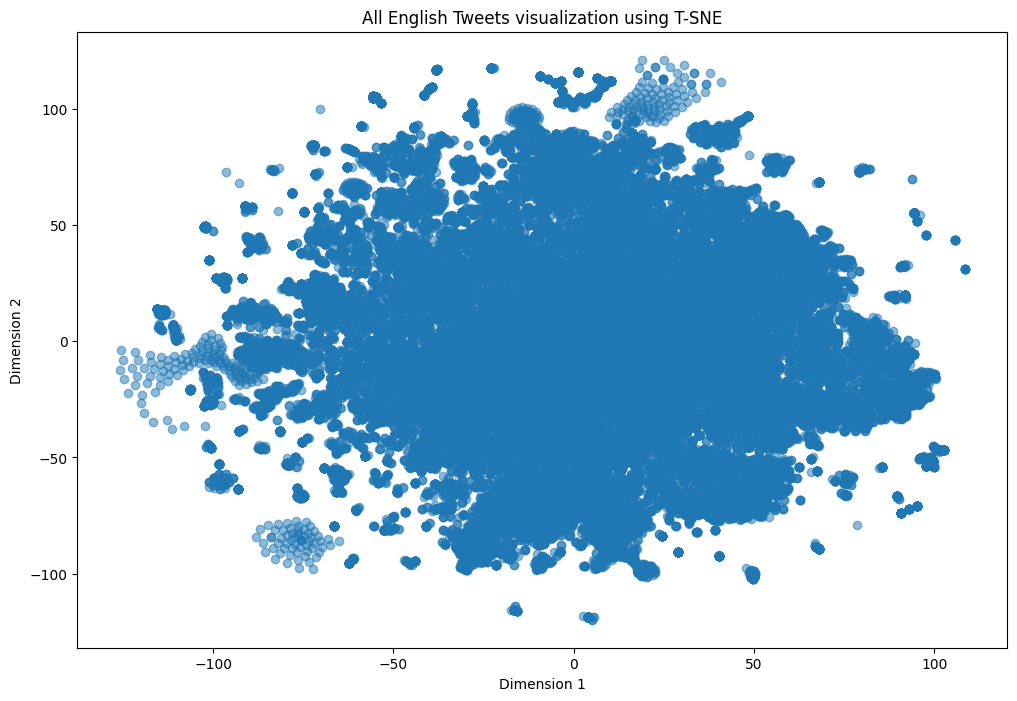

In [53]:
tsne_model = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=40)
tweet_vectors_2d = tsne_model.fit_transform(tweet_vectors)

# Plotting the result of T-SNE
plt.figure(figsize=(12, 8))
plt.scatter(tweet_vectors_2d[:, 0], tweet_vectors_2d[:, 1], alpha=0.5)
plt.title('All English Tweets visualization using T-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [54]:
df_subset_documents['tokenized_content'] = df_subset_documents['content'].apply(lambda x: tokenizer.tokenize(x.lower()))
# Filter out tweets without any words in the model's vocabulary
df_subset_documents = df_subset_documents[df_subset_documents['tokenized_content'].apply(lambda x: any(word in model.wv for word in x))]
# Calculate tweet vectors
df_subset_documents['tweet_vector'] = df_subset_documents['tokenized_content'].apply(
    lambda x: np.mean([model.wv[word] for word in x if word in model.wv], axis=0, keepdims=True)
)
df_subset_documents = df_subset_documents.dropna(subset=['tweet_vector'])
tweet_vectors = np.vstack(df_subset_documents['tweet_vector'].values)

# Apply t-SNE
tsne_model = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=40)
tweet_vectors_2d = tsne_model.fit_transform(tweet_vectors)

df_plot = pd.DataFrame(tweet_vectors_2d, columns=['x', 'y'])
df_plot['docId'] = df_subset_documents['docId'].values
df_plot['query_id'] = df_subset_documents.get('query_id', 'Unknown').values

/var/folders/t1/rkwffv314k333khdlgxlw40m0000gn/T/ipykernel_91418/4047338481.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_documents['tokenized_content'] = df_subset_documents['content'].apply(lambda x: tokenizer.tokenize(x.lower()))
/Users/yuyi/Desktop/IRWA/IRWA/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [55]:
scatter_plot = alt.Chart(df_plot).mark_circle(size=60).encode(
    x='x',
    y='y',
    color='query_id:N', 
    tooltip=['docId', 'query_id']
).properties(
    width=700,
    height=400,
    title='T-SNE of Tweets in Query 1 & 2'
)

scatter_plot.display()

alt.Chart(...)

In [56]:
df_personalized_eva['tokenized_content'] = df_personalized_eva['content'].apply(lambda x: tokenizer.tokenize(x.lower()))
# Filter out tweets where no words match the model vocabulary
df_personalized_eva = df_personalized_eva[df_personalized_eva['tokenized_content'].apply(lambda x: any(word in model.wv for word in x))]
# Compute tweet vectors as the mean of the word vectors
df_personalized_eva['tweet_vector'] = df_personalized_eva['tokenized_content'].apply(lambda x: np.mean([model.wv[word] for word in x if word in model.wv], axis=0))
tweet_vectors = np.vstack(df_personalized_eva['tweet_vector'].values)

# Apply t-SNE
tsne_model = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=40)
tweet_vectors_2d = tsne_model.fit_transform(tweet_vectors)

df_personalized_plot = pd.DataFrame(tweet_vectors_2d, columns=['x', 'y'])
df_personalized_plot['docId'] = df_personalized_eva['docId'].values
df_personalized_plot['query_id'] = df_personalized_eva['query_id'].values

/Users/yuyi/Desktop/IRWA/IRWA/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [57]:
scatter_plot = alt.Chart(df_personalized_plot).mark_circle(size=60).encode(
    x='x',
    y='y',
    color='query_id:N',
    tooltip=['docId', 'query_id']
).properties(
    width=700,
    height=400,
    title='T-SNE of Tweets in Personalized Ground Truth'
)

scatter_plot.display()

alt.Chart(...)